In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
def clean_text(text):
    # remove html tags and url links
    text = re.sub(r'<.*?>', '', text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    
    return text

In [18]:
df = pd.read_csv(r'Data/cleaned_data.csv')
df.head()

,Head,Body,Tags,Text,Tags Count
0,Brain Segmentation To 3D Model,\r\nMy goal is to take a dataset of Brain Tumo...,"['computer-vision', 'python']",brain segmentation model goal dataset brain tu...,2
1,Active Learning regression with Random Forest,\r\nI have a dataset of about 8k points and I ...,"['machine-learning', 'regression', 'uncertaint...",active learning regression random forest I dat...,5
2,Comparing Reinforcement Learning models,\r\nI am currently completing my thesis on opt...,"['reinforcement-learning', 'policy-gradients',...",compare reinforcement learning model I current...,4
3,"Why ""Good Model"" that performs great on holdou...",\r\nI have this binary regression model that h...,"['deep-learning', 'deep-neural-networks', 'pre...",good model perform great holdout validation da...,5
4,What are Reservoir computers used for today?,\r\nReservoir computers were very popular in t...,"['machine-learning', 'recurrent-neural-network...",reservoir computer use today reservoir compute...,3


In [19]:
from ast import literal_eval
df['Tags'] = df['Tags'].apply(lambda x: literal_eval(x))
all_tags = [item for sublist in df['Tags'].values for item in sublist]
print(len(all_tags))

153141


In [20]:
my_set = set(all_tags)
unique_tags = list(my_set)
print(len(unique_tags))
from collections import Counter
counts = Counter(all_tags)
counts.most_common(20)

2686


[('machine-learning', 8147),
 ('r', 4186),
 ('regression', 3840),
 ('deep-learning', 3435),
 ('neural-networks', 3003),
 ('data-request', 2527),
 ('python', 2503),
 ('reinforcement-learning', 2346),
 ('classification', 2200),
 ('time-series', 2039),
 ('probability', 1635),
 ('neural-network', 1419),
 ('distributions', 1371),
 ('bayesian', 1250),
 ('hypothesis-testing', 1174),
 ('keras', 1044),
 ('mathematical-statistics', 1001),
 ('scikit-learn', 983),
 ('logistic', 961),
 ('convolutional-neural-networks', 924)]

In [21]:
frequencies_words = counts.most_common(35)
tags_features = [word[0] for word in frequencies_words]
print(tags_features)

['machine-learning', 'r', 'regression', 'deep-learning', 'neural-networks', 'data-request', 'python', 'reinforcement-learning', 'classification', 'time-series', 'probability', 'neural-network', 'distributions', 'bayesian', 'hypothesis-testing', 'keras', 'mathematical-statistics', 'scikit-learn', 'logistic', 'convolutional-neural-networks', 'clustering', 'tensorflow', 'terminology', 'nlp', 'correlation', 'self-study', 'normal-distribution', 'geospatial', 'cross-validation', 'optimization', 'random-forest', 'mixed-model', 'data-mining', 'feature-selection', 'pca']


In [22]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

df['Tags'] = df['Tags'].apply(lambda x: most_common(x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [23]:
df.dropna(subset=['Tags'], inplace=True)
df.shape

(36526, 5)

In [24]:
X = df['Text']
y = df['Tags']

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

bin = MultiLabelBinarizer()
y_bin = bin.fit_transform(y)

In [28]:
import pickle

with open('Data/binarizer.pkl', 'wb') as f:
    pickle.dump(bin, f)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer = 'word', max_features=1000)
X = tfidf.fit_transform(df['Text'])

In [12]:
X.shape, y_bin.shape

((35585, 1000), (35585, 30))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3, random_state = 0)

In [14]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

lr = LogisticRegression()
svc = LinearSVC()
sgd = SGDClassifier()

for classifier in [lr, svc, sgd]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classifier.__class__.__name__, accuracy_score(y_test, y_pred))
    print(classifier.__class__.__name__, f1_score(y_test, y_pred, average='micro'))

LogisticRegression 0.28072311727238664
LogisticRegression 0.4995661336308417
LinearSVC 0.3117272386661671
LinearSVC 0.5404198652671158
SGDClassifier 0.27997377294866993
SGDClassifier 0.48770632737276476


# Deep Models

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,plot_model

In [31]:
token = Tokenizer()
token.fit_on_texts(df['Text'].to_list())

In [32]:
print(len(token.word_counts))
vocab_size = len(token.word_index) + 1
print(vocab_size)

48835
48836


In [34]:
encoded_text = token.texts_to_sequences(df['Text'].to_list())

In [ ]:
with open('Data/tokenizer.pkl', 'wb') as f:
    pickle.dump(token, f)

In [19]:
max_length = 512
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [20]:
X.shape, y_bin.shape

((35585, 512), (35585, 30))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, random_state = 42, test_size = 0.2)

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_bin.shape[1], activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model)

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
                ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=callbacks)

import matplotlib.pyplot as plt
import seaborn as sns
def plot_graph():
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.plot(history.history['loss'],label='loss')
    plt.legend()
    plt.show()
    pass

plot_graph()

In [22]:
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout, Conv1D

In [27]:
model2 = Sequential()
model2.add(Embedding(vocab_size +1, 128, input_length = max_length))
model2.add(Dropout(0.15))
model2.add(Conv1D(300, 5, padding = 'valid', activation = "relu", strides = 1))
model2.add(GlobalMaxPool1D())
model2.add(Dense(30, activation = "softmax"))

In [28]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 128)          13958400  
                                                                 
 dropout_1 (Dropout)         (None, 512, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 508, 300)          192300    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 30)                9030      
                                                                 
Total params: 14,159,730
Trainable params: 14,159,730
Non-trainable params: 0
__________________________________________

In [29]:
callbacks = [
             EarlyStopping(patience=3),
             ModelCheckpoint(filepath='model-conv1d_v1.h5', save_best_only=True)
            ]

In [30]:
# train model
history2 = model2.fit(X_train, y_train,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/15
401/401 [==============================] - 88s 185ms/step - loss: 0.1655 - accuracy: 0.3090 - val_loss: 0.1134 - val_accuracy: 0.4756
Epoch 2/15
401/401 [==============================] - 42s 105ms/step - loss: 0.1008 - accuracy: 0.5223 - val_loss: 0.1004 - val_accuracy: 0.5216
Epoch 3/15
401/401 [==============================] - 30s 74ms/step - loss: 0.0863 - accuracy: 0.5707 - val_loss: 0.0962 - val_accuracy: 0.5304
Epoch 4/15
401/401 [==============================] - 21s 53ms/step - loss: 0.0750 - accuracy: 0.6107 - val_loss: 0.0977 - val_accuracy: 0.5272
Epoch 5/15
401/401 [==============================] - 18s 46ms/step - loss: 0.0639 - accuracy: 0.6523 - val_loss: 0.0993 - val_accuracy: 0.5177
Epoch 6/15
401/401 [==============================] - 18s 45ms/step - loss: 0.0528 - accuracy: 0.6877 - val_loss: 0.1043 - val_accuracy: 0.5181


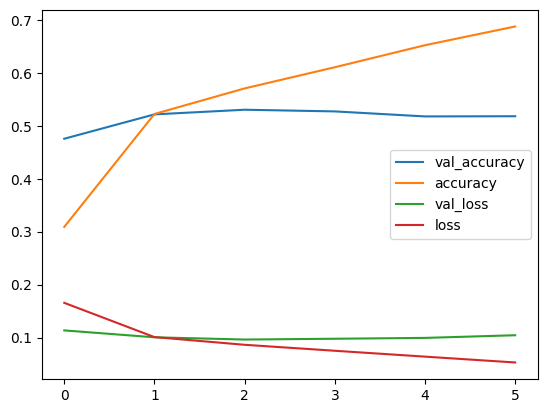

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_graph():
    plt.plot(history2.history['val_accuracy'],label='val_accuracy')
    plt.plot(history2.history['accuracy'],label='accuracy')
    plt.plot(history2.history['val_loss'],label='val_loss')
    plt.plot(history2.history['loss'],label='loss')
    plt.legend()
    plt.show()
    pass

plot_graph()

In [32]:
preds = model2.predict(X_test)

223/223 [==============================] - 1s 3ms/step


In [33]:
preds.shape

(7117, 30)

In [34]:
# set threshold to 0.3
preds_int = (preds >= 0.3).astype(int)

In [35]:
from sklearn.metrics import f1_score

# calculate F1 score
f1_score(y_test, preds_int, average="micro")

0.556808835624486

In [44]:
import re
def infer_tags(q):
    q = clean_text(q)
    q = q.lower()
    q_seq = token.texts_to_sequences([q])
    q_seq_padded = pad_sequences(q_seq, maxlen=512)
    q_pred = model2.predict(q_seq_padded)
    q_pred = (q_pred >= 0.25).astype(int)
    
    return bin.inverse_transform(q_pred)

In [45]:
# give new question
new_q = """I am given a number of short texts (very likely to be shorter than 25 words). The specificity of the short texts is that it can (logically) belong to one or multiple categories. For example:

find the closest starbucks and then remind me to call bob
The short text can be attributed two labels: NAVIGATION and PHONE. I have a large number of short texts like this and most of them have 2 parts, very rarely 3 parts. The word ``and'' not always is the clear indicator of part separation!

My question: How can I approach such classification problem? What techniques/ideas are worth exploring?

I am currently thinking about two approaches:

Try multilabel classifier such as MPBoost;
Perform some pre-segmentation using CRF and then classify each segment using a standard multiclass classifier."""
# get tags
infer_tags(new_q)

1/1 [==============================] - 0s 19ms/step


[('classification', 'machine-learning')]